In [1]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

## Non-exonic windows, with Gnocchi and various features (e.g. GC content), and enhancer-overlap status 

In [2]:
import pandas as pd
from functools import reduce

def get_windows_with_GC_content_and_cpg_islands(): 
  df1 = pd.read_csv(
    f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2.gnocchi.N_expected.N_observed.B.paternal_recombination_rate.maternal_recombination_rate.gBGC-tract-counts.non-exonic.gBGC.bed', 
    sep='\t', 
  )

  for gc_window_size in [
    1000, 
    10000, 
    100000,
    1000000,
  ]:
    df_temp = pd.read_csv(
      f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2.GC_content_{gc_window_size}.bed', 
      sep='\t', 
    )
    df_temp = df_temp[['chen_chrom', 'chen_start', 'chen_end', 'window_GC_content']]
    df_temp = df_temp.rename(columns={
      'chen_chrom': 'chrom', 
      'chen_start': 'start', 
      'chen_end': 'end',
      'window_GC_content': f'GC_content_{gc_window_size}bp'
    })
    df1 = pd.merge(df1, df_temp, on=['chrom', 'start', 'end'], how='inner')

  # created using: experiments/germline-model/chen-et-al-2022/cpg-island-enrichment.ipynb
  df2 = pd.read_csv(
    f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/mchale.kmerSizes.trainSets.noisy.enhancer-exon-cpgIsland.bed',
    sep='\t', 
  )
  df2 = df2[['chromosome', 'start', 'end', 'cpg_island overlap', 'window overlaps cpg_island']]
  df2 = df2.rename(columns={
    'chromosome': 'chrom', 
    'cpg_island overlap': 'cpg_island_overlap', 
    'window overlaps cpg_island': 'window_overlaps_cpg_island'
  })

  dfs = [df1, df2]
  df = reduce(lambda left, right: pd.merge(left, right, on=['chrom', 'start', 'end'], how='inner'), dfs)

  return df

WINDOWS = get_windows_with_GC_content_and_cpg_islands()
WINDOWS 

,chrom,start,end,gnocchi,N_expected,N_observed,window overlaps enhancer,window overlaps merged_exon,B,paternal_recombination_rate,...,B0_M3starHMT6.EUR,B1_M3starHMT6.EUR,Bmean_M3starHMT6.EUR,lambda_M3starHMT6.EUR,GC_content_1000bp,GC_content_10000bp,GC_content_100000bp,GC_content_1000000bp,cpg_island_overlap,window_overlaps_cpg_island
0,chr1,1432000,1433000,4.299894,338.059552,259,True,False,0.653,0.039046,...,0.057741,0.513191,0.105518,2.585568,0.661339,0.641836,0.565094,0.577534,NaN,False
1,chr1,1451000,1452000,0.666316,302.590657,291,False,False,0.652,0.039046,...,0.057741,0.513191,0.105518,2.585568,0.556444,0.552845,0.572894,0.575506,NaN,False
2,chr1,1453000,1454000,0.828398,269.601925,256,False,False,0.651,0.039046,...,0.057741,0.513191,0.105518,2.585568,0.537463,0.561944,0.572564,0.575129,NaN,False
3,chr1,1458000,1459000,-0.086128,270.583243,272,False,False,0.651,0.039046,...,0.057741,0.513191,0.105518,2.585568,0.532468,0.596740,0.570774,0.575225,NaN,False
4,chr1,1463000,1464000,2.948188,236.321790,191,True,False,0.651,0.039046,...,0.057741,0.513191,0.105518,2.585568,0.540460,0.568843,0.576514,0.574420,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019146,chr9,137262000,137263000,-2.396149,263.131293,302,True,False,0.536,0.057053,...,0.135944,3.636507,0.219258,2.281162,0.500499,0.542646,0.611944,0.568316,45.0,True
1019147,chr9,137268000,137269000,3.640544,272.046527,212,True,False,0.536,0.057053,...,0.135944,3.636507,0.219258,2.281162,0.552448,0.589941,0.613074,0.567839,NaN,False
1019148,chr9,137269000,137270000,5.276351,300.458958,209,True,False,0.536,0.057053,...,0.135944,3.636507,0.219258,2.281162,0.519481,0.585042,0.613494,0.567623,NaN,False
1019149,chr9,137275000,137276000,2.687348,339.517045,290,True,False,0.536,1.564889,...,0.135944,3.636507,0.219258,2.281162,0.603397,0.639236,0.610484,0.567380,NaN,False


## Baseline classifier

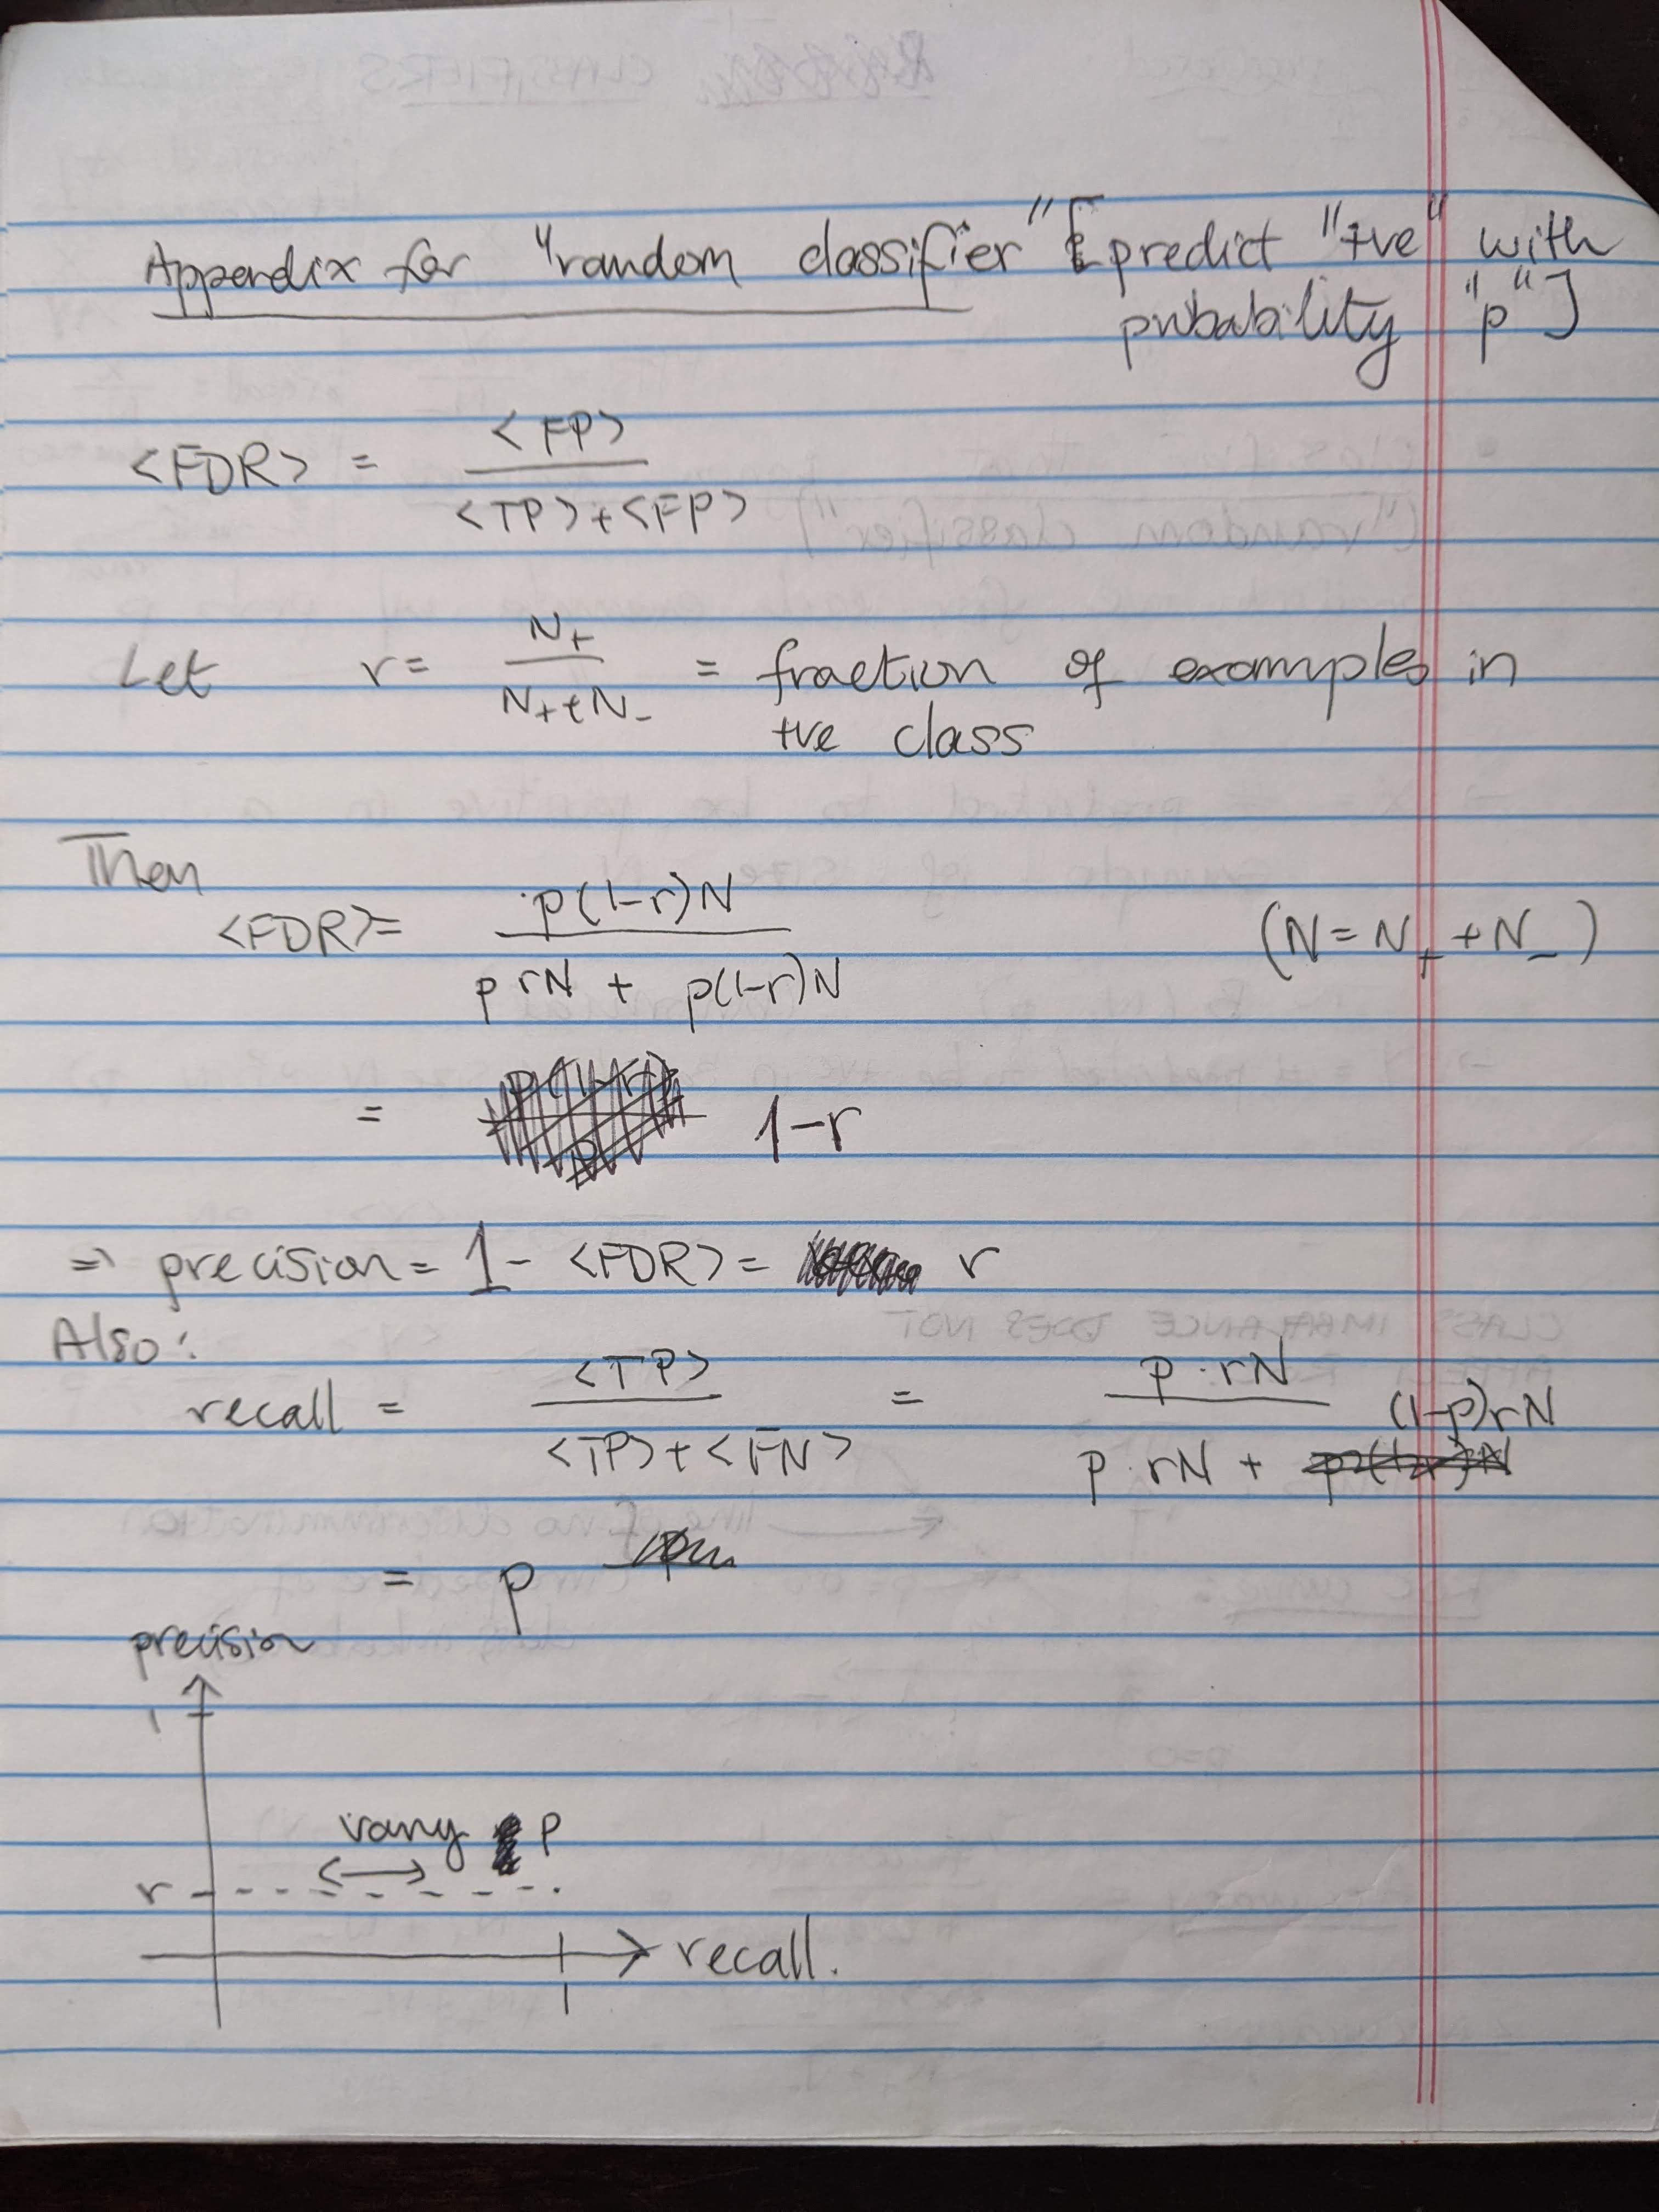

In [3]:
from IPython.display import Image # type: ignore
Image(filename='precision_recall_random_classifier.jpg', width=600)

## Features that negatively impact a Gnocchi-based classifier

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import precision_recall_curve

mpl.rcParams['font.size'] = 20

def compute_positive_fraction(df, target):
  # this is "r" in the baseline-classifier theory 

  value_counts = df[target].value_counts()
  number_negative_examples = value_counts.get(False, 0)
  number_positive_examples = value_counts.get(True, 0)

  return number_positive_examples / (number_negative_examples + number_positive_examples)

def plot_random_classifier(df, target, color, axis):
  r = compute_positive_fraction(df, target)
  axis.plot([0, 1], [r, r], linestyle='--', linewidth=3, color=color, label='random classifier')  

def downsample(df, group_columns, target):
  positive_class_sizes = df.groupby(group_columns)[target].apply(lambda ser: ser.value_counts().get(True, 0))
  negative_class_sizes = df.groupby(group_columns)[target].apply(lambda ser: ser.value_counts().get(False, 0))  
  positive_to_negative_ratios = positive_class_sizes/negative_class_sizes
  min_positive_to_negative_ratio = positive_to_negative_ratios.min()

  def downsample_positive_class(group):
    negative_class = group[group[target] == False]
    negative_class_size = len(negative_class)
    positive_class = group[group[target] == True]
    new_positive_class_size = int(min_positive_to_negative_ratio*negative_class_size)
    positive_class_downsampled = positive_class.sample(new_positive_class_size)
    return pd.concat([positive_class_downsampled, negative_class])
  
  df_downsampled = df.groupby(group_columns).apply(downsample_positive_class).reset_index(drop=True)

  return df_downsampled

def preprocess(df, feature, target, number_bins): 
  df = df.copy() 
  df[f'{feature}_bin'] = pd.cut(df[f'{feature}'], bins=number_bins) 
  df = downsample(
    df, 
    group_columns=[f'{feature}_bin'], 
    target=target
  )
  return df 

def plot_precision_recall_all(feature, number_bins, target='window overlaps enhancer', ylim=None): 
  df = WINDOWS 

  fig, ax = plt.subplots(figsize=(10, 10))
  plt.hist(df[feature], bins=50, color='black')
  ax.set_xlabel(feature)
  ax.set_ylabel('Number of windows')
  ax.grid(False)
  plt.show()

  df = preprocess(df, feature, target, number_bins)

  fig, ax = plt.subplots(figsize=(10, 10))
  cmap = cm.get_cmap('inferno')

  for i, feature_bin in enumerate(sorted(df[f'{feature}_bin'].unique())): 
    df_bin = df[df[f'{feature}_bin'] == feature_bin]
    if len(df_bin) < 5000: continue
    print(feature_bin)
    color = cmap(i / number_bins)
    targets, scores = df_bin[target], df_bin['gnocchi']
    precision, recall, _ = precision_recall_curve(targets, scores)
    plt.plot(recall, precision, color=color, linestyle='-', label=f'{feature} in {feature_bin}')

  r = compute_positive_fraction(df, target)

  plot_random_classifier(
    df, 
    target, 
    color='black', 
    axis=ax,
  )
  
  ax.grid(False)
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
  ax.set_xlabel('Recall')
  ax.set_ylabel('Precision')
  ax.set_xlim(0, 1)
  if not ylim: 
    ax.set_ylim(0, 2*r)
  else: 
    ax.set_ylim(ylim)
  plt.show()

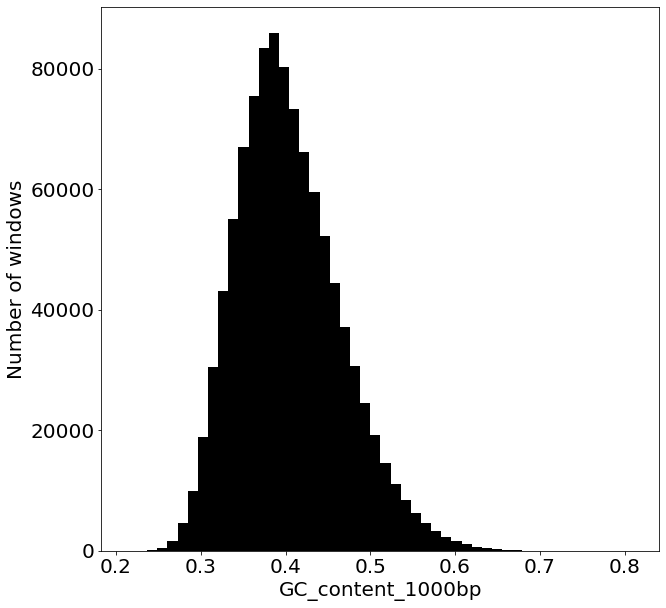

(0.212, 0.313]
(0.313, 0.412]
(0.412, 0.512]
(0.512, 0.612]


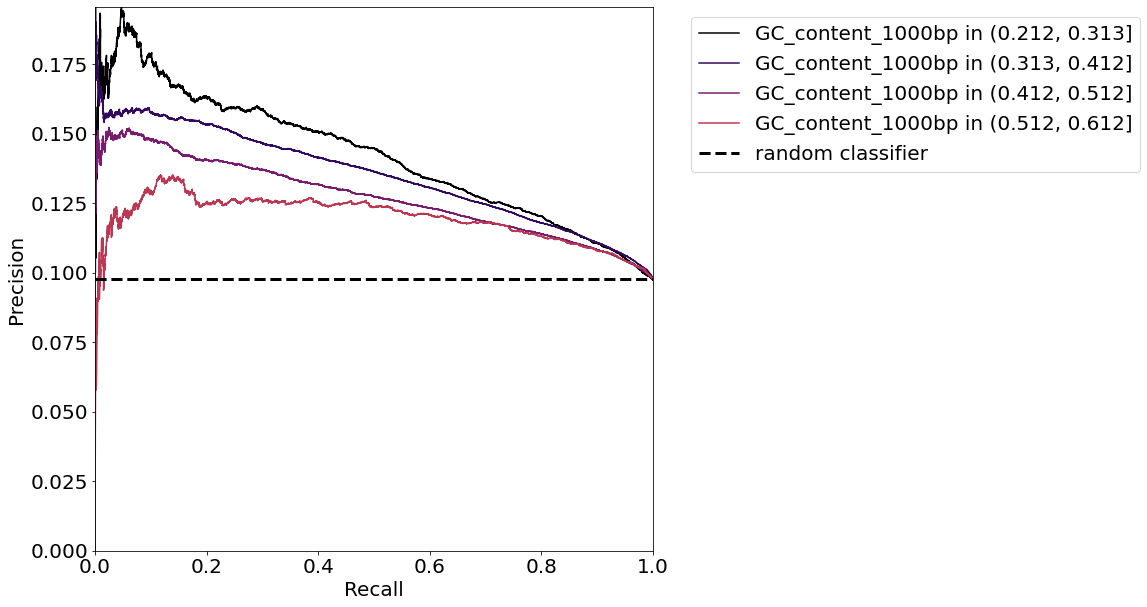

In [5]:
plot_precision_recall_all(feature='GC_content_1000bp', number_bins=6)

In [6]:
# plot_precision_recall_all(feature='GC_content_100000bp', number_bins=5)

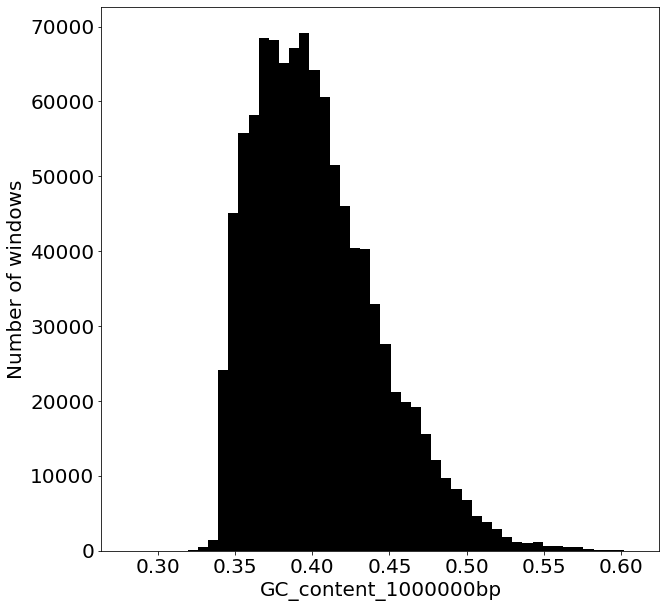

(0.321, 0.362]
(0.362, 0.403]
(0.403, 0.444]
(0.444, 0.485]
(0.485, 0.526]


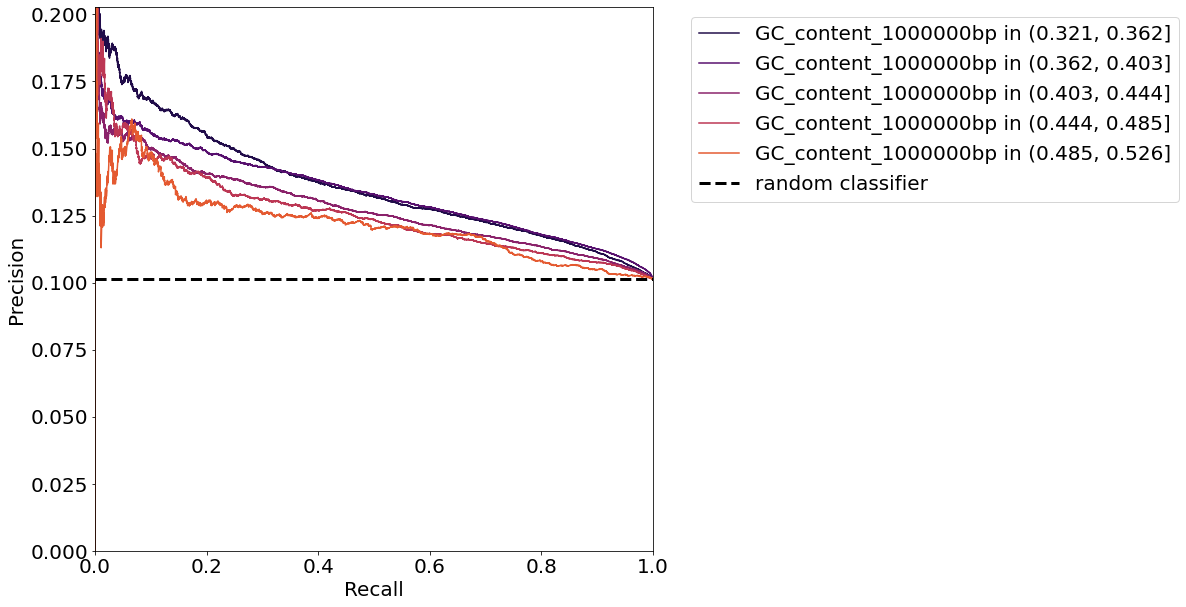

In [7]:
plot_precision_recall_all(feature='GC_content_1000000bp', number_bins=8)

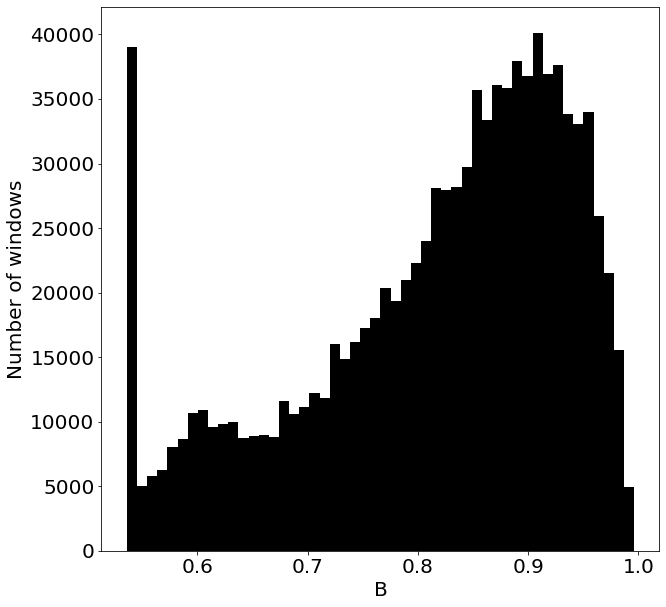

(0.536, 0.613]
(0.613, 0.689]
(0.689, 0.766]
(0.766, 0.843]
(0.843, 0.919]
(0.919, 0.996]


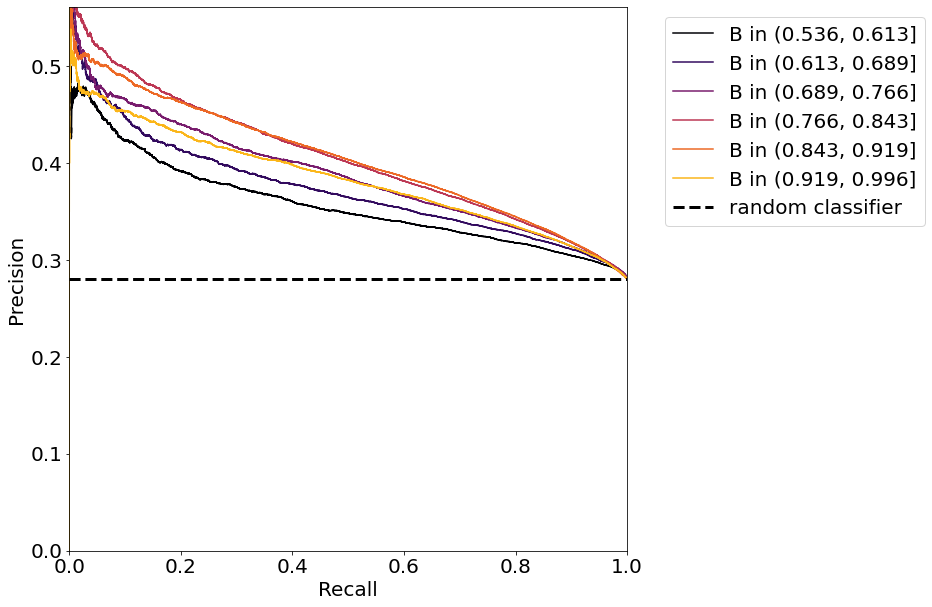

In [8]:
plot_precision_recall_all(feature='B', number_bins=6)

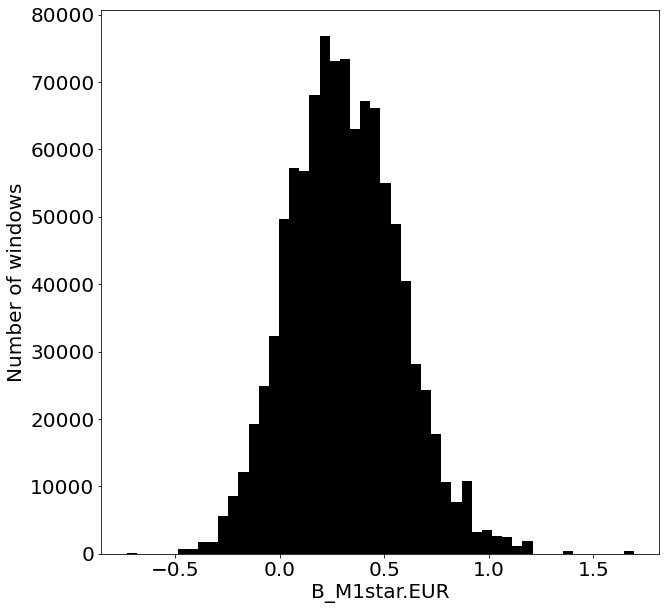

(-0.385, -0.0383]
(-0.0383, 0.308]
(0.308, 0.655]
(0.655, 1.001]
(1.001, 1.348]


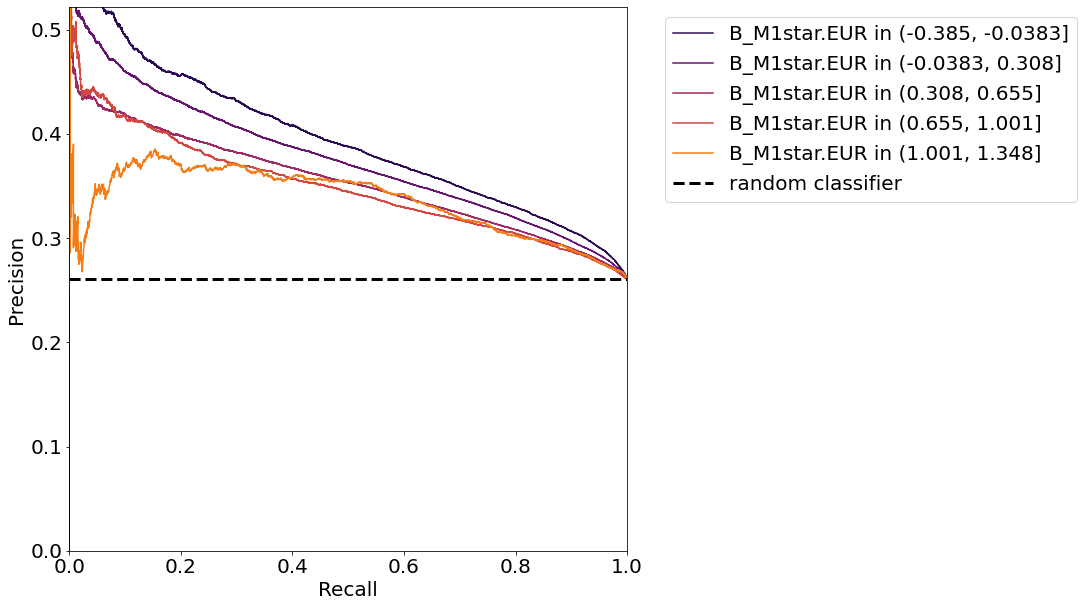

In [9]:
plot_precision_recall_all(feature='B_M1star.EUR', number_bins=7)

## Comparing the impact of different features on a Gnocchi-based classifier

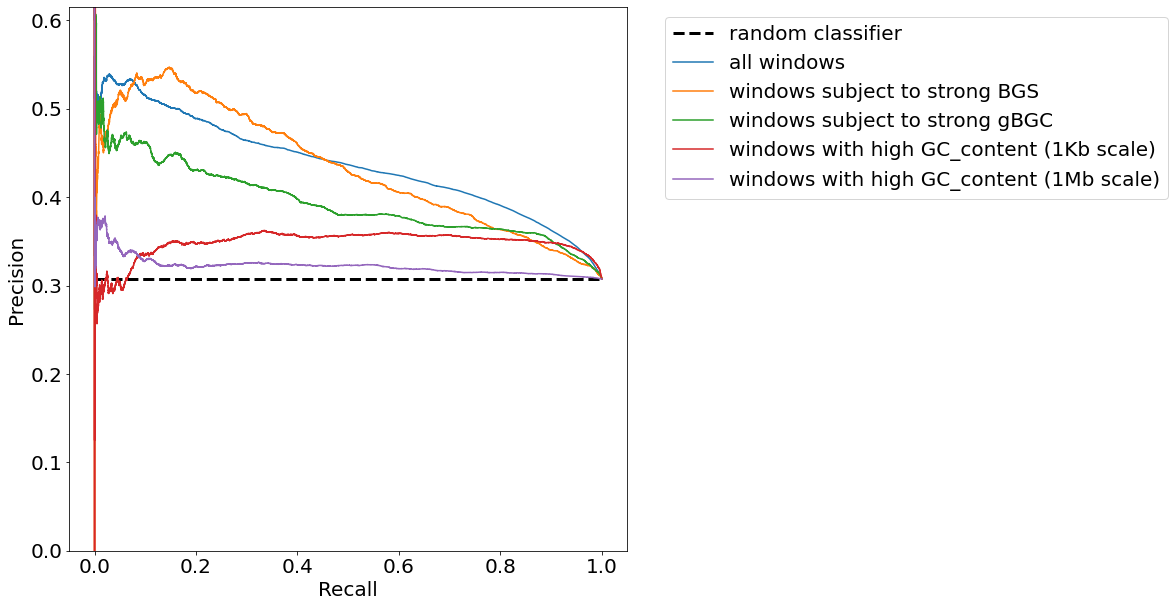

In [10]:
def get_subset(df, feature, feature_min, feature_max, target): 
  subset = df[
    (df[feature] > feature_min) & 
    (df[feature] < feature_max)
  ]
  r = compute_positive_fraction(subset, target)
  return subset, r

def resample_subset(df, target, r, label):
  negative_class = df[df[target] == False]
  positive_class = df[df[target] == True]
  new_positive_class_size = int(r*len(negative_class)/(1-r))
  if new_positive_class_size > len(positive_class): 
    print(label)
    raise ValueError('new_positive_class_size > old_positive_class_size)')
  positive_class_downsampled = positive_class.sample(new_positive_class_size)
  df = pd.concat([positive_class_downsampled, negative_class])
  return df 

def plot_precision_recall_all_features(df, target):
  subsets_and_labels, rs = [], []

  subsets_and_labels.append((df, 'all windows'))
  rs.append(compute_positive_fraction(df, target))

  features_and_labels_and_values = [
    ('B', 'windows subject to strong BGS', 0.536, 0.613),
    ('B_M1star.EUR', 'windows subject to strong gBGC', 0.655, 1.001),
    ('GC_content_1000bp', 'windows with high GC_content (1Kb scale)', 0.512, 0.612),
    ('GC_content_1000000bp', 'windows with high GC_content (1Mb scale)', 0.444, 0.485)
  ]
  for feature, label, feature_min, feature_max in features_and_labels_and_values:
    subset, r = get_subset(df, feature, feature_min, feature_max, target)
    subsets_and_labels.append((subset, label))
    rs.append(r)
  
  r_min = min(rs)
  
  resampled_subsets_and_labels = [
    (resample_subset(subset, target, r_min, label), label)
    for subset, label in subsets_and_labels
  ]

  pr_curves_and_labels = [
    (precision_recall_curve(subset[target], subset[feature]), label)
    for subset, label in resampled_subsets_and_labels
  ]

  plt.figure(figsize=(10, 10))

  plt.plot([0, 1], [r_min, r_min], linestyle='--', linewidth=3, color='black', label='random classifier')  

  for pr_curve, label in pr_curves_and_labels:
    precision, recall, _ = pr_curve
    plt.plot(recall, precision, label=label)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.ylim(0, 2*r_min)
  plt.show()

plot_precision_recall_all_features(WINDOWS, target='window overlaps enhancer')